# inicialização

In [116]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
import plotly.express as px
import os
import sys

sys.path.append("..")

from structureSelector import *
from structureSelector2 import structureSelectorV2
from methods.utils.utilities import *

def metrics(y, yest):
    residuo1 = y - yest
    index = np.where(y != 0)
    mape = round(np.mean(np.abs(residuo1[index] / y[index])) * 100, 3)
    mse = np.mean(np.square(residuo1))
    rmse = np.sqrt(mse)
    aet = np.sum(np.abs(residuo1))
    print('RMSE:', round(rmse, 4),'\nMSE:', round(mse, 4), '\nAET:', round(aet, 4), '\nMAPE:', str(round(mape, 5)) + '%')
    coeficiente_corr = np.corrcoef(y, yest)[0, 1]
    print("Coeficiente de correlação:", coeficiente_corr)
    #print(y.shape, yest.shape)

# Uniform

## preparação

In [117]:
mat_content2 = sc.loadmat("../data/DATAUNIF.MAT")

print(mat_content2.keys())
u11 = mat_content2['u11']
z11 = mat_content2['z11']

u12 = mat_content2['u12']
z12 = mat_content2['z12']


t = np.arange(0, 500, 1)#np.arange(0, 10, 0.02)
fig=px.line(x=t, y=np.squeeze(z11), height=400, width=1300)
fig.add_scatter(x=t, y=np.squeeze(u11), mode='lines')
#fig.add_scatter(x=t, y=np.squeeze(zc11), mode='lines')

fig.show()

dict_keys(['u11', 'u12', 'z11', 'z12'])


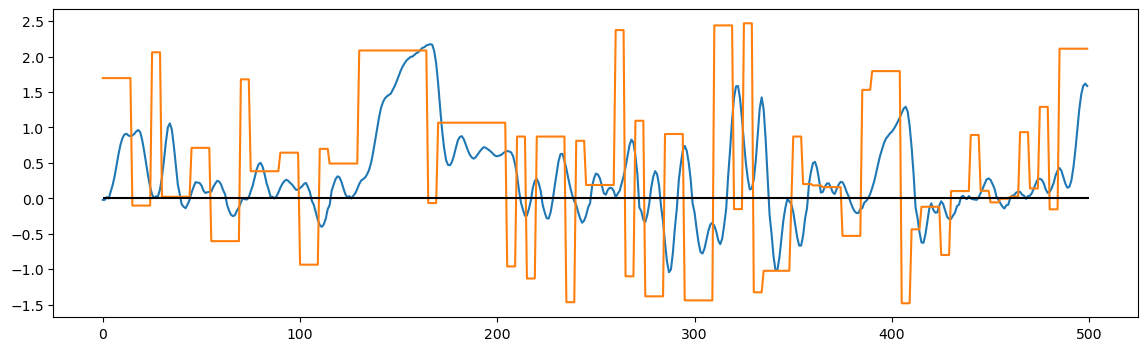

In [118]:
zc11 = z11.copy()

l1 = np.array([26, 40, 63, 106, 212, 223, 239, 272, 283, 299, 338, 379, 412, 454])
l2 = np.array([28, 45, 73, 116, 218, 229, 248, 278, 292, 317, 358, 389, 435, 460])
'''
l1 = np.array([40, 63, 106, 212, 223, 239, 272, 283, 299, 338, 379, 412, 454, 480])
l2 = np.array([45, 73, 116, 218, 229, 248, 278, 292, 317, 347, 389, 435, 460, 490])

l1 = np.array([40, 63, 106, 212, 223, 239, 272, 283, 299, 338, 379, 412, 454])
l2 = np.array([45, 73, 116, 218, 229, 248, 278, 292, 317, 357, 389, 435, 460])
'''

for i in range(l1.shape[0]):
    zc11[l1[i]: l2[i]] *= -1

plt.figure(figsize=(14,4))
plt.plot(zc11)
plt.plot(u11)
plt.hlines(0, 0, 500, colors='black')
plt.show()

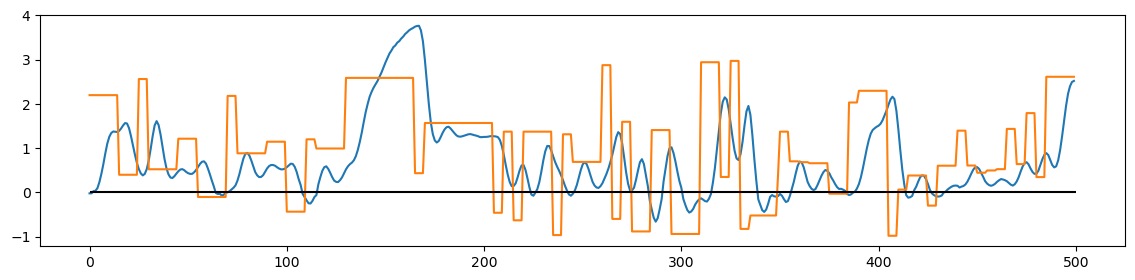

In [119]:
zc12 = z12.copy()
l1 = np.array([64, 108, 224, 243, 284, 301, 339, 384, 414, 427])
l2 = np.array([71, 116, 227, 246, 291, 316, 356, 388, 418, 434])

for i in range(l1.shape[0]):
    zc12[l1[i]: l2[i]] *= -1

plt.figure(figsize=(14,3))
plt.plot(zc12)
plt.plot(u12)
plt.hlines(0, 0, 500, colors='black')
plt.show()

## Estimação

### N abs

[Y1.1 U1.4 U1.5*Y1.10*tanh2(Y1.1) Y1.10 U1.6 U1.3*U1.9**2 Y1.3 U1.7
 U1.10*Y1.6 U1.5**2*tanh2(Y1.1)] [ 1.09044652  0.03368588  0.02805315  0.04100245  0.0205516   0.00813204
 -0.34065918  0.02114784  0.01867876  0.00914348]
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, Y1.7, Y1.8, Y1.9, Y1.10, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10]

Simulação livre
RMSE: 0.0852 
MSE: 0.0073 
AET: 31.3717 
MAPE: 92.878%
Coeficiente de correlação: 0.9899499825012337


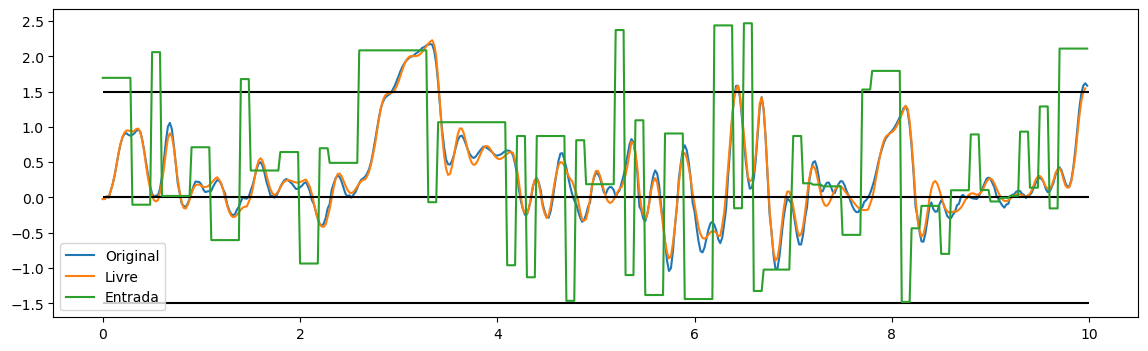

'\nprint("\nSimulação livre Absolute")\nmetrics(z11[:, 0], np.abs(slivre))\n\nSimulação livre\nRMSE: 0.1124 \nMSE: 0.0126 \nAET: 40.9181 \nMAPE: 108.246%\nCoeficiente de correlação: 0.9826060717489598\n\nSimulação livre\nRMSE: 0.1113 \nMSE: 0.0124 \nAET: 40.294 \nMAPE: 107.264%\nCoeficiente de correlação: 0.9829055003775857\n'

In [121]:
output = 0  # 0 ou 1

y = zc11.copy()
u = u11.copy()
num = [12]
params = []

params.append({'nb':[10],'na':[10], 'level':3, 'nonlinear':[0,0,0,1,0, 1, 0, 0, 0], 'root':False, 'delay':2, 'diff':False}) 
#params.append({'nb':[10],'na':[10], 'level':3, 'nonlinear':[0,0,0,1,0, 1, 0, 0, 0], 'root':False, 'delay':0, 'diff':False}) #11
#params.append({'nb':[6],'na':[8], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]

print(model, theta)
#print(model @ np.round(theta, 5))

slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)

'''print("\nUm passo a frente")
metrics(y[:, 0], yhat)'''
print("\nSimulação livre")
metrics(y[:, 0], slivre)

fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(14, 4))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()

'''
print("\nSimulação livre Absolute")
metrics(z11[:, 0], np.abs(slivre))

Simulação livre
RMSE: 0.1124 
MSE: 0.0126 
AET: 40.9181 
MAPE: 108.246%
Coeficiente de correlação: 0.9826060717489598

Simulação livre
RMSE: 0.1113 
MSE: 0.0124 
AET: 40.294 
MAPE: 107.264%
Coeficiente de correlação: 0.9829055003775857
'''

## Validação

Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, Y1.7, Y1.8, Y1.9, Y1.10, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10]

Simulação livre
RMSE: 0.1068 
MSE: 0.0114 
AET: 38.5658 
MAPE: 29.081%
Coeficiente de correlação: 0.9912190906663202

Um passo a frente
RMSE: 0.0528 
MSE: 0.0028 
AET: 15.8938 
MAPE: 24.5%
Coeficiente de correlação: 0.9979420693360067


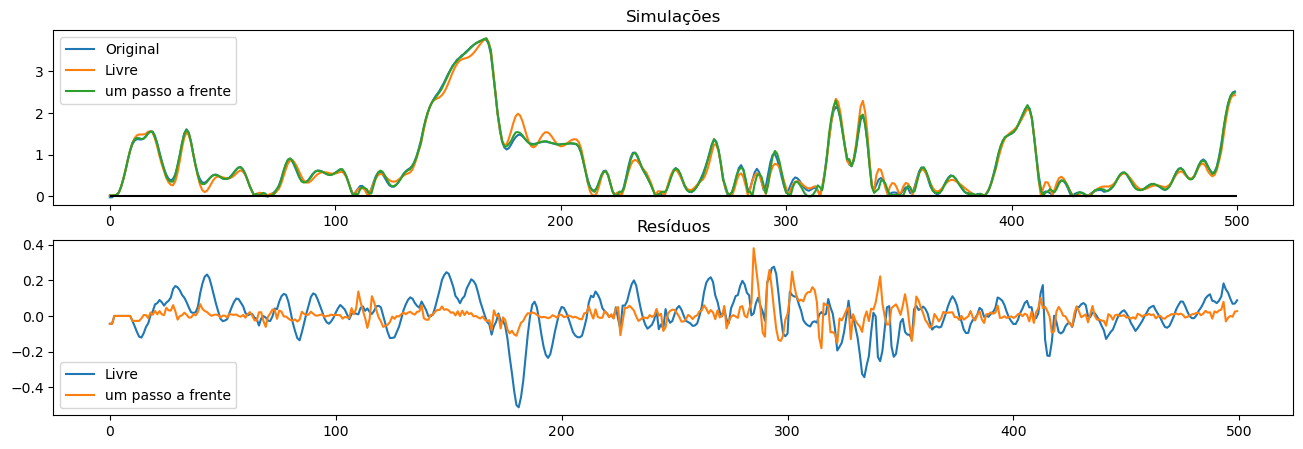

In [140]:
uVal = u12.T
yVal = z12.T

yValHat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("\nSimulação livre")
metrics(yVal[0, :], np.abs(valLivre))
print("\nUm passo a frente")
metrics(yVal[0, :], np.abs(yValHat))

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(valLivre, label='Livre')
ax[0].plot(np.abs(valLivre), label='Livre')
#ax[0].plot(np.abs(yValHat), label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - np.abs(valLivre), label='Livre')
ax[1].plot(yVal[output].T - np.abs(yValHat), label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

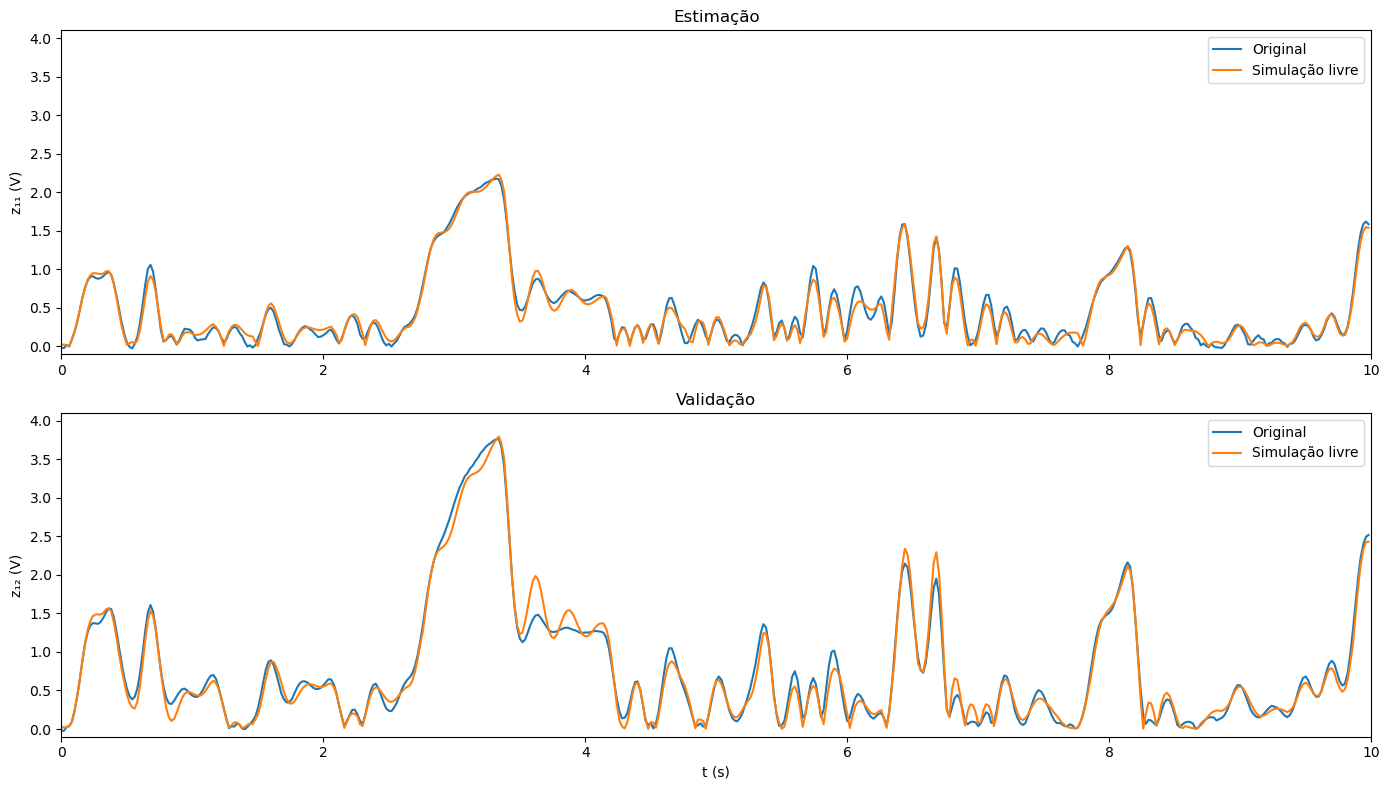

In [138]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 8])
ax[0].plot(p, z11, label='Original')
ax[0].plot(p, np.abs(slivre), label='Simulação livre')
ax[0].set_ylabel('z\u2081\u2081 (V)')
ax[0].set_ylim(-0.1, 4.1)
ax[0].set_xlim(0, 10)
ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(p, z12, label='Original')
ax[1].plot(p, np.abs(valLivre), label='Simulação livre')
ax[1].set_ylabel('z\u2081\u2082 (V)')
ax[1].set_xlabel('t (s)')
ax[1].set_ylim(-0.1, 4.1)
ax[1].set_xlim(0, 10)
ax[1].set_title("Validação")
ax[1].legend()

plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/coupledrivesResult.png')

plt.show()

## polinomial sem não linearidades adicionais

### N abs

[Y1.1 U1.4 Y1.9 U1.3*U1.9**2 U1.6 U1.5*U1.6*Y1.10 Y1.3] [ 1.16518682  0.03193008  0.05273634  0.00922605  0.02902627  0.01202051
 -0.35791768]
0.00923*U1.3*U1.9**2 + 0.03193*U1.4 + 0.01202*U1.5*U1.6*Y1.10 + 0.02903*U1.6 + 1.16519*Y1.1 - 0.35792*Y1.3 + 0.05274*Y1.9
Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, Y1.7, Y1.8, Y1.9, Y1.10, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10]


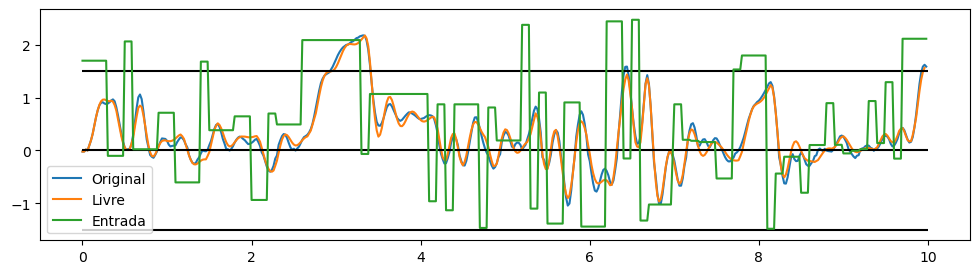


Simulação livre
RMSE: 0.0922 
MSE: 0.0085 
AET: 35.5465 
MAPE: 105.285%
Coeficiente de correlação: 0.9885955435012143

Um passo a frente
RMSE: 0.0396 
MSE: 0.0016 
AET: 13.5375 
MAPE: 40.413%
Coeficiente de correlação: 0.9978036442529916


In [17]:
output = 0  # 0 ou 1

y = zc11.copy()
u = u11.copy()
num = [8, 6]
params = []
params.append({'nb':[10],'na':[10], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False}) #9

#params.append({'nb':[6],'na':[8], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]

print(model, theta)
print(model @ np.round(theta, 5))

polinomial_slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
polinomial_yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)


fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(12,3))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], polinomial_slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()

print("\nSimulação livre")
metrics(y[:, 0], polinomial_slivre)
print("\nUm passo a frente")
metrics(y[:, 0], polinomial_yhat)
#Y1.1 Y1.2 Y1.4 U1.3 U1.4*Y1.1 Y1.3 Y1.6*tanh(Y1.1) U1.5*U1.6
#Y1.1 Y1.2 Y1.6 U1.3*U1.7**2 U1.4 Y1.3 U1.6*Y1.6 U1.1*U1.7*tanh(U1.1)

Simulação livre
--------s:  [Y1.1, Y1.2, Y1.3, Y1.4, Y1.5, Y1.6, Y1.7, Y1.8, Y1.9, Y1.10, U1.0, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8, U1.9, U1.10]
Modelo selecionado:
                2                                                             
0.0092⋅U1.3⋅U1.9  + 0.0319⋅U1.4 + 0.012⋅U1.5⋅U1.6⋅Y1.10 + 0.029⋅U1.6 + 1.1652⋅

                                
Y1.1 - 0.3579⋅Y1.3 + 0.0527⋅Y1.9


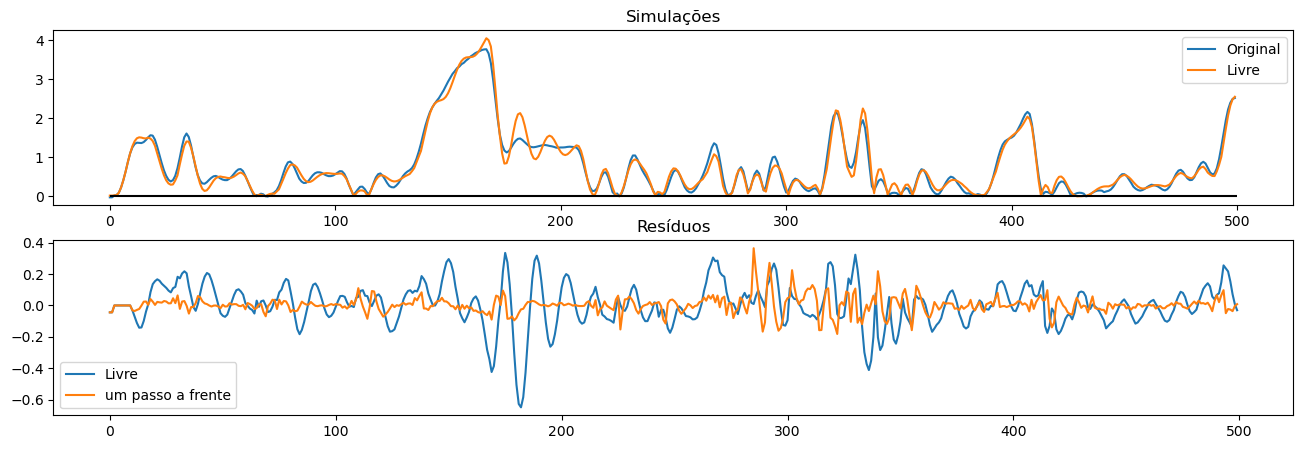


Simulação livre
RMSE: 0.1339 
MSE: 0.0179 
AET: 49.02 
MAPE: 34.786%
Coeficiente de correlação: 0.9862203041778015

Um passo a frente
RMSE: 0.0538 
MSE: 0.0029 
AET: 17.1897 
MAPE: 27.151%
Coeficiente de correlação: 0.9978331333657049


In [18]:
uVal = u12.T
yVal = z12.T

polinomial_yValHat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
polinomial_valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ np.round(theta, 4))

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(polinomial_valLivre, label='Livre')
ax[0].plot(np.abs(polinomial_valLivre), label='Livre')
#ax[0].plot(polinomial_yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - np.abs(polinomial_valLivre), label='Livre')
ax[1].plot(yVal[output].T - np.abs(polinomial_yValHat), label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

print("\nSimulação livre")
metrics(yVal[0, :], np.abs(polinomial_valLivre))
print("\nUm passo a frente")
metrics(yVal[0, :], np.abs(polinomial_yValHat))


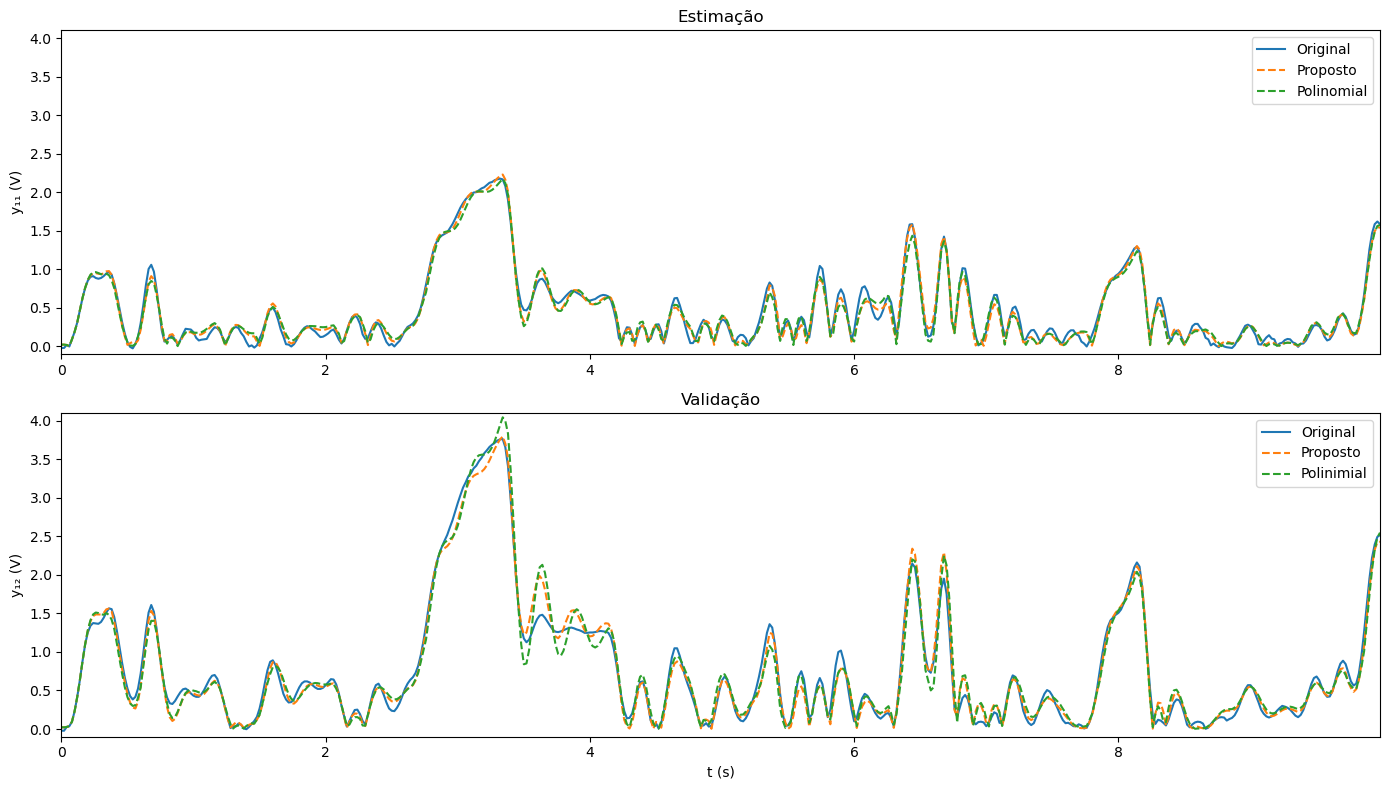

In [136]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 8])
ax[0].plot(p, z11, label='Original')
ax[0].plot(p, np.abs(slivre), '--', label='Proposto')
ax[0].plot(p, np.abs(polinomial_slivre), '--', label='Polinomial')

ax[0].set_ylabel('y\u2081\u2081 (V)')
ax[0].set_ylim(-0.1, 4.1)
ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(p, z12, label='Original')
ax[1].plot(p, np.abs(valLivre), '--', label='Proposto')
ax[1].plot(p, np.abs(polinomial_valLivre), '--', label='Polinimial')
ax[1].set_ylabel('y\u2081\u2082 (V)')
ax[1].set_xlabel('t (s)')
ax[1].set_ylim(-0.1, 4.1)
ax[1].set_title("Validação")
ax[1].legend()

ax[0].set_xlim(0, 9.98)
ax[1].set_xlim(0, 9.98)
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/coupledrivesComparate.png')

plt.show()

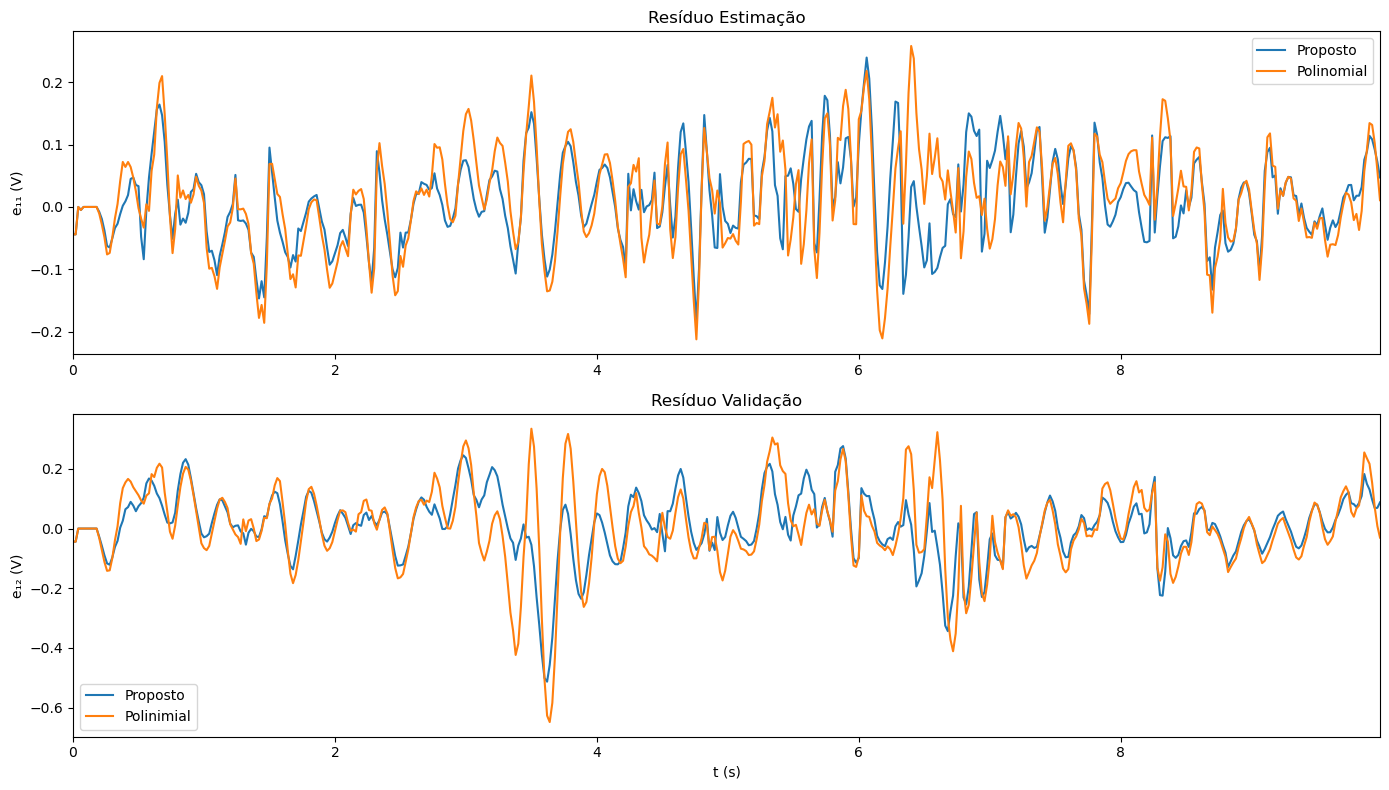

In [134]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 8])

ax[0].plot(p, z11[:,0] - np.abs(slivre), label='Proposto')
ax[0].plot(p, z11[:,0] - np.abs(polinomial_slivre), label='Polinomial')

ax[0].set_ylabel('e\u2081\u2081 (V)')
ax[0].set_title("Resíduo Estimação")
ax[0].legend()

ax[1].plot(p, z12[:,0] - np.abs(valLivre), label='Proposto')
ax[1].plot(p, z12[:,0] - np.abs(polinomial_valLivre), label='Polinimial')
ax[1].set_ylabel('e\u2081\u2082 (V)')# "x\u00b2 + y\u00b2 = 2"
ax[1].set_xlabel('t (s)')
ax[1].set_title("Resíduo Validação")
ax[1].legend()

ax[0].set_xlim(0, 9.98)
ax[1].set_xlim(0, 9.98)
plt.tight_layout() 
plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/coupledrivesResiduo.png')

plt.show()